# WaveNet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

### Data Load

In [3]:
# 데이터 로드
X = torch.load('training_set_X.tensor')
y = torch.load('training_set_Y.tensor')

print("X's shape: ", X.shape) # (열, Timestamp, input size)
print("y's shape: ", y.shape) # 1, 3, 4, 5, 6, 7, 8 - (열, Timestamp, class)

# Dataset 만들기
dataset = TensorDataset(X, y)

# Input feature의 개수를 dynamic하게 입력받기
input_size = X.shape[2]
num_classes = y.shape[1]
time_interval = 30
hidden_dim = 150

print("Input size: ", input_size, "\nTime interval T: ", time_interval, "\nHidden dimension size : ",hidden_dim, "\nOutput size: ", num_classes)


# Train / validation으로 나누기
train_size = int(0.8 * len(dataset)) # train 비율: 80%
val_size = len(dataset) - train_size # valid 비율: 20%
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # 일반적으로 검증데이터의 shuffle은 False로

X's shape:  torch.Size([40133, 30, 6])
y's shape:  torch.Size([40133, 7])
Input size:  6 
Time interval T:  30 
Hidden dimension size :  150 
Output size:  7


### WaveNet Model
*nn.ModuleList* <br/>
: Module들을 PyTorch에 list로 wrapping - Dilated causal convolution을 반복적으로 사용

In [38]:
class WaveNet(nn.Module):
    def __init__(self, input_size, num_classes, time_interval, hidden_dim):
        super(WaveNet, self).__init__()
        
        # Input layer
        self.fc1 = nn.Linear(input_size, hidden_dim) 
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(p=0.5)
        
        # Dilated causal convolution
        self.dilations = [1, 2, 4, 8, 16]
        self.conv_layers = nn.ModuleList() # convolution layer의 list
        self.bn_layers = nn.ModuleList() # BN list
        self.dropout_layers = nn.ModuleList() # Dropout list
        in_channels = hidden_dim
        
        for dilation in self.dilations:
            kernel_size = 3
            self.conv_layers.append(
                # WaveNet의 dilated conv layer는 input과 output의 size가 같음
                nn.Conv1d(in_channels = in_channels, out_channels = time_interval, kernel_size = kernel_size, dilation = dilation)
            )
            self.bn_layers.append(nn.BatchNorm1d(time_interval))
            self.dropout_layers.append(nn.Dropout(p=0.5))
            in_channels = time_interval

        # Output layer
        self.fc2 = nn.Linear(time_interval * time_interval, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)
        self.dropout2 = nn.Dropout(p=0.5)


    def forward(self, x): # x: (N, T, D)
        N, T, D = x.size() # N: 배치 크기, T: 타임스텝, D: 입력 크기
        
        # Input layer
        x = self.fc1(x.view(-1, D)).view(N, T, -1) # 2차원으로 바꾼 후 다시 3차원으로
        x = self.bn1(x.permute(0, 2, 1)).permute(0, 2, 1) # BatchNorm1d는 (N, C, L)으로 입력받음
        x = F.relu(x)
        x = self.dropout1(x)

        x = x.permute(0, 2, 1) # convolution layer는 (N, C_in, L)으로 입력받음

        # Convolution layer
        for conv, bn, dropout, dilation in zip(self.conv_layers, self.bn_layers, self.dropout_layers, self.dilations): 
            # Shifting으로 인해 비는 사이즈: dilation * (kernel_size - 1)
            insert_length = dilation * (conv.kernel_size[0] - 1)
            
            # 1: Zero padding
            x_tmp = torch.zeros(x.size(0), x.size(1), x.size(2) + insert_length) # 임시로 0.0 텐서 생성
            
            # 2: 평균값 padding
            '''
            fill_value = torch.mean(x, dim=2, keepdim=True)
            x_tmp[:, :, :insert_length] = fill_value.repeat(1, 1, insert_length)'''

            x_tmp[:, :, insert_length:] = x
            x = conv(x_tmp) # (N, C_out, L)
            
            x = bn(x)
            x = F.relu(x)
            x = dropout(x)

        x = x.permute(0, 2, 1) # 원상태로: (N, L, C_in) - (32, 30, 30)
        x = x.reshape(N, -1) # (N, L * C_in)

        # Output layer
        x = self.fc2(x) # (N, num_classes)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = F.softmax(x, dim=1)

        return x

model = WaveNet(input_size, num_classes, time_interval, hidden_dim)

### Training & Evaluation

Epoch [10/100], Loss: -0.5807, Validation Accuracy: 86.03%
Epoch [20/100], Loss: -0.5887, Validation Accuracy: 88.19%
Epoch [30/100], Loss: -0.5915, Validation Accuracy: 88.78%
Epoch [40/100], Loss: -0.5962, Validation Accuracy: 88.60%
Epoch [50/100], Loss: -0.5997, Validation Accuracy: 89.55%
Epoch [60/100], Loss: -0.5985, Validation Accuracy: 89.98%
Epoch [70/100], Loss: -0.6023, Validation Accuracy: 90.15%
Epoch [80/100], Loss: -0.6013, Validation Accuracy: 90.01%
Epoch [90/100], Loss: -0.6034, Validation Accuracy: 89.85%
Epoch [100/100], Loss: -0.6005, Validation Accuracy: 90.44%


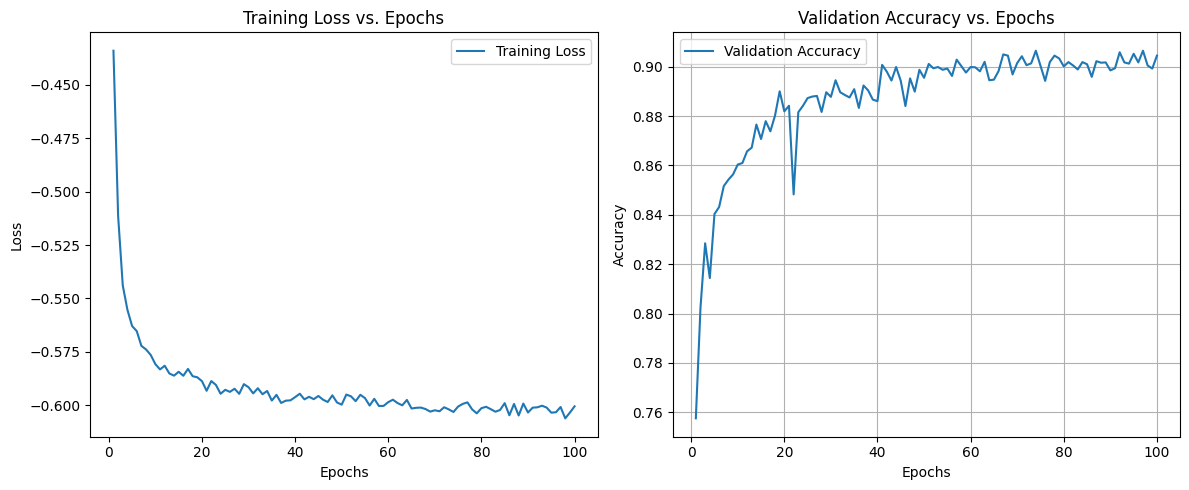

In [39]:
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

num_epochs = 100
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0 # 누적되는 loss 초기화

    for batch_X, batch_y in train_loader: # batch_y: (32, 7)
        # Forward pass
        outputs = model(batch_X) # (32, 30, 6) -> (32, 7)
        
        # Loss
        loss = criterion(outputs, batch_y)
        
        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # epoch의 loss
    train_losses.append(running_loss / len(train_loader))
    
    # Evaluation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            outputs = model(val_X) # softmax가 적용된 상태
            _, predicted = torch.max(outputs, 1) #각 샘플의 가장 높은 값 비교하기
            
            val_total += val_y.size(0)
            val_correct += (predicted == val_y.argmax(dim=1)).sum().item() # 가장 높은 값끼리 비교
    
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
    
    # Loss 출력
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Matplot
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# 첫 번째 graph'
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()

# 두 번째 graph
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), 'mlp_model.pth')  # Model의 가중치 저장
    